In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV

In [56]:
data_path = 'data/'

timeframe = 'monthly'

if timeframe == 'quarterly':
    timescale = 4
elif timeframe == 'monthly':
    timescale = 1

In [59]:
total = pd.read_csv(data_path + f'co2_m_processed.csv', delimiter=',', header=0, encoding='latin-1')
total['date'] = pd.to_datetime(total['date'])
total = total[['country', 'date', 'co2_m']]
total

,country,date,co2_m
0,Afghanistan,2000-01-01,4.112056e+05
1,Afghanistan,2000-02-01,4.116877e+05
2,Afghanistan,2000-03-01,3.791312e+05
3,Afghanistan,2000-04-01,2.349278e+05
4,Afghanistan,2000-05-01,1.781820e+05
...,...,...,...
50395,Zimbabwe,2019-08-01,3.439962e+06
50396,Zimbabwe,2019-09-01,2.545628e+06
50397,Zimbabwe,2019-10-01,2.602864e+06
50398,Zimbabwe,2019-11-01,2.468584e+06


In [63]:
# total_lag = total.copy()

# for col in total_lag.columns[2:]:
#     val = total_lag.set_index('date').groupby('country').resample('MS').asfreq()[col]
#     val = np.log(val.groupby(level=0))
#     total_lag[f'{col}_lag'] = total_lag.set_index(['country', 'date']).index.map(val)

# total_lag = total_lag.dropna(axis=0, how='any')
# total_lag = total_lag.reset_index(drop=True)
# total_lag

In [64]:
total = total

In [91]:
target_countries = ['Iceland', 'Ireland', 'France', 'Portugal', 'Switzerland']

donor_countries = ['Austria', 'Belgium', 'Bulgaria', 
#                    'Cyprus', 
                   'Croatia', 'Czech Republic',
                   'Germany', 'Greece', 'Hungary', 'Italy', 'Lithuania', 'Netherlands', 
                   'Romania', 'Slovakia', 'Spain']

incl_years = pd.to_datetime(total['date']).dt.year.unique()
print(list(incl_years))
incl_countries = target_countries + donor_countries
incl_countries.sort()
print(len(incl_countries))
print(incl_countries)

[2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
19
['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Czech Republic', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy', 'Lithuania', 'Netherlands', 'Portugal', 'Romania', 'Slovakia', 'Spain', 'Switzerland']


In [92]:
target_country = 'France'
donor_countries = total[total['country']!='France']['country'].unique()
incl_years = pd.to_datetime(total['date']).dt.year.unique()

target_var = f'co2_{timeframe}'
impl_year = 2014

print(len(donor_countries))
print(donor_countries)

209
['Afghanistan' 'Albania' 'Algeria' 'Angola' 'Anguilla'
 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Aruba' 'Australia' 'Austria'
 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus'
 'Belgium' 'Belize' 'Benin' 'Bermuda' 'Bhutan' 'Bolivia'
 'Bosnia and Herzegovina' 'Botswana' 'Brazil' 'Brunei Darussalam'
 'Bulgaria' 'Burkina Faso' 'Burundi' 'Cambodia' 'Cameroon' 'Canada'
 'Cape Verde' 'Cayman Islands' 'Central African Republic' 'Chad' 'Chile'
 'China' 'Colombia' 'Comoros' 'Congo'
 'Congo_the Democratic Republic of the' 'Cook Islands' 'Costa Rica'
 "Cote d'Ivoire" 'Croatia' 'Cuba' 'Cyprus' 'Czech Republic' 'Denmark'
 'Djibouti' 'Dominica' 'Dominican Republic' 'Ecuador' 'Egypt'
 'El Salvador' 'Equatorial Guinea' 'Eritrea' 'Estonia' 'Ethiopia'
 'Falkland Islands (Malvinas)' 'Faroe Islands' 'Fiji' 'Finland'
 'French Guiana' 'French Polynesia' 'Gabon' 'Gambia' 'Georgia' 'Germany'
 'Ghana' 'Gibraltar' 'Greece' 'Greenland' 'Grenada' 'Guadeloupe'
 'Guatemala' 'Guinea' 'Guine

In [93]:
donors = total.copy()
donors = donors[donors['country'].isin(donor_countries)].reset_index(drop=True)
donors = donors.pivot(index='date',columns=['country'], values=donors.columns[2:])
donors.columns = donors.columns.to_flat_index()
donors.columns = [str(col_name[1]) + ' '+ str(col_name[0]) for col_name in donors.columns]
donors = donors.reindex(sorted(donors.columns), axis=1)
donors = donors.dropna(axis=1)
donors

,Afghanistan co2_m,Albania co2_m,Algeria co2_m,Angola co2_m,Anguilla co2_m,Antigua and Barbuda co2_m,Argentina co2_m,Armenia co2_m,Aruba co2_m,Australia co2_m,...,Uruguay co2_m,Uzbekistan co2_m,Vanuatu co2_m,Venezuela co2_m,Viet Nam co2_m,Virgin Islands_British co2_m,Western Sahara co2_m,Yemen co2_m,Zambia co2_m,Zimbabwe co2_m
date,,,,,,,,,,,,,,,,,,,,,
2000-01-01,4.112056e+05,536805.8473,9.286794e+06,2759198.572,1173.215857,43977.76130,12852296.78,444228.7311,75033.57737,33445637.28,...,4.910314e+05,1.798314e+07,15549.73655,1.245804e+07,27010380.43,10694.78347,40331.64761,1.189182e+06,9.687543e+05,2575343.179
2000-02-01,4.116877e+05,442626.5710,7.919410e+06,2772074.092,1220.951812,43384.21613,13215394.03,411458.2047,77599.50073,33440827.74,...,4.874311e+05,1.580737e+07,15703.43739,1.228916e+07,21039375.63,11082.87591,18685.22798,1.172049e+06,9.803933e+05,2577451.899
2000-03-01,3.791312e+05,443304.9824,6.522585e+06,2886074.406,1283.939518,43074.40873,15751487.90,372663.3703,81692.95611,35268973.81,...,5.574943e+05,1.312780e+07,16481.13677,1.259792e+07,13128990.32,11722.63505,19441.83279,1.233426e+06,1.104714e+06,2847429.009
2000-04-01,2.349278e+05,339885.5028,6.455934e+06,2951142.688,1313.214211,39658.79540,17082707.59,288899.1879,79657.33290,37030869.25,...,6.286768e+05,7.211520e+06,16653.83597,1.276107e+07,14478141.45,11301.69492,19324.91026,1.229964e+06,1.178757e+06,2984865.504
2000-05-01,1.781820e+05,320851.2986,6.393553e+06,2876712.090,1340.776859,37205.21985,17747260.12,265560.3800,86673.92728,37188697.92,...,8.282515e+05,6.815395e+06,16282.88403,1.236776e+07,11934916.06,12532.09304,20125.19543,1.251736e+06,1.095042e+06,4390015.071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-01,7.579402e+05,445991.5305,1.328812e+07,3921209.362,2356.832793,58312.42739,22192394.69,354839.2038,119780.41610,39171822.06,...,2.087748e+06,6.912154e+06,23504.97141,9.419986e+06,34037376.90,17686.20158,18013.44086,9.327298e+05,1.871728e+06,3439962.129
2019-09-01,9.440695e+05,468741.2920,1.316453e+07,4275280.224,2339.532458,76829.76969,24856816.59,369893.7406,105740.52210,37008468.14,...,2.075849e+06,7.452022e+06,24147.46105,1.019947e+07,37351307.69,15688.62244,17328.83673,9.173779e+05,2.092089e+06,2545627.830
2019-10-01,1.184080e+06,500953.8479,1.371464e+07,4568861.757,2456.179721,49106.70964,25364011.41,553219.0662,130573.92030,38876540.86,...,1.975914e+06,9.831499e+06,25910.60387,9.803519e+06,41283446.03,19270.37377,19539.78757,1.043224e+06,2.245972e+06,2602863.887


In [94]:
for col in donors.columns:
    donors[col] = np.log(donors[col]).diff(12)
    
donors = donors.dropna(axis=0)
donors

,Afghanistan co2_m,Albania co2_m,Algeria co2_m,Angola co2_m,Anguilla co2_m,Antigua and Barbuda co2_m,Argentina co2_m,Armenia co2_m,Aruba co2_m,Australia co2_m,...,Uruguay co2_m,Uzbekistan co2_m,Vanuatu co2_m,Venezuela co2_m,Viet Nam co2_m,Virgin Islands_British co2_m,Western Sahara co2_m,Yemen co2_m,Zambia co2_m,Zimbabwe co2_m
date,,,,,,,,,,,,,,,,,,,,,
2001-01-01,0.111395,-0.184428,-0.037442,-0.000218,0.022038,-0.004072,-0.027183,-0.020883,0.026639,0.038637,...,-0.095966,0.073200,0.069547,0.035717,-1.084928,0.013164,-0.080610,0.947867,0.026207,0.021350
2001-02-01,-0.065241,-0.019136,0.013280,-0.000471,0.021603,-0.004024,-0.027246,-0.039464,0.022340,0.038485,...,-0.097571,0.000421,0.060344,0.036688,-0.830294,0.007855,0.331416,0.249594,0.024069,0.016373
2001-03-01,-0.038937,-0.144949,-0.030194,0.004472,0.022874,-0.004431,-0.012591,-0.045050,0.027213,0.036443,...,-0.099327,-0.102030,0.056428,0.036153,-0.025033,0.013651,0.009947,0.058863,0.012372,0.019250
2001-04-01,0.027644,0.153251,-0.018975,0.007348,0.023201,-0.005331,0.007341,0.054987,0.022662,0.018219,...,0.013571,0.070728,0.055142,0.027326,0.002233,0.007827,0.006895,0.056390,0.006704,0.011682
2001-05-01,-0.038287,0.048268,-0.017581,0.004007,0.025061,-0.005800,-0.000438,0.030309,0.026105,0.008265,...,0.049348,0.001442,0.058402,0.023880,0.007263,0.011273,0.009363,0.058461,0.013904,-0.398387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-01,-0.053491,-0.045767,0.017922,0.036469,-0.022903,-0.007887,-0.025273,0.048521,0.027481,-0.010994,...,0.010977,0.055604,-0.002850,-0.154763,0.150217,-0.226027,0.031747,0.167197,-0.045468,-0.018812
2019-09-01,-0.005491,-0.044582,0.017395,0.034287,-0.023014,-0.008103,0.005185,0.041148,0.027384,-0.012777,...,0.037424,0.057708,-0.002410,-0.155551,0.125802,-0.224430,0.031732,0.174239,-0.056509,-0.059460
2019-10-01,0.013035,-0.041838,0.017131,0.033766,-0.023377,-0.007624,0.020496,0.052925,0.027609,-0.014683,...,0.054892,0.049278,-0.002580,-0.155978,0.116123,-0.226235,0.031744,0.164274,-0.061860,-0.075728


In [95]:
for col in donors.columns:
    donor_series = donors[col]
    adf_test = adfuller(donor_series)
    if adf_test[1] < 0.1:
#         print(f'{col}: Stationary')
        pass
    if adf_test[1] >= 0.1:
        print(f'{col}: Non-stationary ({adf_test[1]})')

Afghanistan co2_m: Non-stationary (0.23972161100156225)
Benin co2_m: Non-stationary (0.14272719047779991)
Brazil co2_m: Non-stationary (0.5775976681554577)
Cambodia co2_m: Non-stationary (0.11659336485698862)
Cameroon co2_m: Non-stationary (0.12853710797269308)
China co2_m: Non-stationary (0.4162593303170389)
Costa Rica co2_m: Non-stationary (0.1625625367329701)
Cyprus co2_m: Non-stationary (0.11306135300933029)
Equatorial Guinea co2_m: Non-stationary (0.24588712431158727)
Faroe Islands co2_m: Non-stationary (0.6311575561396259)
Ghana co2_m: Non-stationary (0.39491384945396674)
Greece co2_m: Non-stationary (0.16195460383937643)
Int. Aviation co2_m: Non-stationary (0.16286456977464753)
Int. Shipping co2_m: Non-stationary (0.12261448565382521)
Korea, Democratic People's Republic of co2_m: Non-stationary (0.20062380685788073)
Macao co2_m: Non-stationary (0.23660968070057203)
Malta co2_m: Non-stationary (0.2363862629054853)
Martinique co2_m: Non-stationary (0.12422485184001208)
Netherlands

In [102]:
X_cols = list(donors.columns)
X_orig = donors[X_cols]

y = np.array(np.log(total[total['country']=='France'][target_var]).diff(12).dropna()).reshape(-1,1)
X = np.array(donors[X_cols])

### Sandardization of data ###
PredictorScaler = StandardScaler()
TargetVarScaler = StandardScaler()

# Storing the fit object for later reference
PredictorScalerFit = PredictorScaler.fit(X)
TargetVarScalerFit = TargetVarScaler.fit(y)

# Generating the standardized values of X and y
X = PredictorScalerFit.transform(X)
y = TargetVarScalerFit.transform(y)
 
# Split the data into training and testing set
ts = int((2019 - impl_year + 1)*(12/timescale))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts, random_state=42)
 
# Quick sanity check with the shapes of Training and testing datasets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(156, 209)
(156, 1)
(72, 209)
(72, 1)


Text(0, 0.5, 'weights')

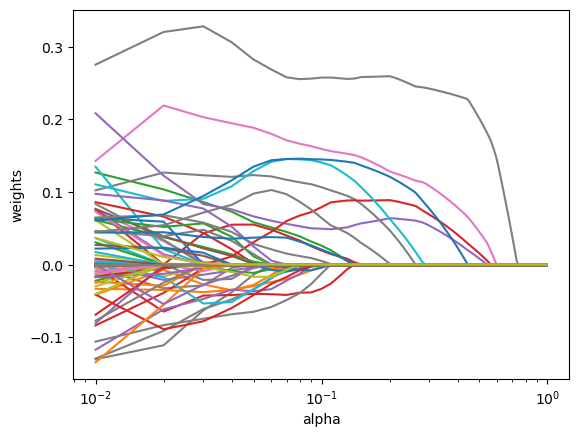

In [103]:
alphas = np.arange(0.01,1,0.01)

lasso = Lasso(max_iter=10000)
coefs = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

In [104]:
# define model evaluation method
tscv = TimeSeriesSplit(n_splits=round(len(X_train)/5))
# define model
model = LassoCV(
                alphas=np.arange(0.01, 2, 0.001), 
#                 alphas=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], 
                cv=tscv,
                fit_intercept=True,
                max_iter=100000,
                tol=0.00001
               )
# fit model
model.fit(X_train, y_train.ravel())
# summarize chosen configuration
print('alpha: %f' % model.alpha_)

alpha: 0.029000


In [105]:
# print(model.alpha_)
# print(model.coef_X)
# print(model.intercept_)
# print(model.score)
# print(model.get_params)

coefs = list(model.coef_)
coef_index = [i for i, val in enumerate(coefs) if val != 0]
coef_index

print(len(X_orig.columns[coef_index]))
print(X_orig.columns[coef_index])

coeffs = model.coef_
print(coeffs[coeffs != 0])

42
Index(['Armenia co2_m', 'Azerbaijan co2_m', 'Bahamas co2_m',
       'Bahrain co2_m', 'Bangladesh co2_m', 'Belgium co2_m',
       'Bhutan co2_m', 'Bosnia and Herzegovina co2_m',
       'Bulgaria co2_m', 'Chad co2_m', 'Chile co2_m',
       'Croatia co2_m', 'Dominica co2_m', 'Fiji co2_m',
       'Finland co2_m', 'Gambia co2_m', 'Guadeloupe co2_m',
       'Guatemala co2_m', 'Hong Kong co2_m',
       'Indonesia co2_m', 'Int. Shipping co2_m',
       'Italy co2_m', 'Korea, Republic of co2_m',
       'Lao People's Democratic Republic co2_m', 'Lithuania co2_m',
       'Luxembourg co2_m', 'Malaysia co2_m', 'Morocco co2_m',
       'Paraguay co2_m', 'Philippines co2_m',
       'Portugal co2_m', 'Russian Federation co2_m',
       'Slovenia co2_m', 'Spain co2_m', 'Swaziland co2_m',
       'Switzerland co2_m', 'Tajikistan co2_m',
       'Tunisia co2_m', 'Turkey co2_m',
       'United Kingdom co2_m', 'Virgin Islands_British co2_m',
       'Zimbabwe co2_m'],
      dtype='object')
[-3.04200313e-02 -2

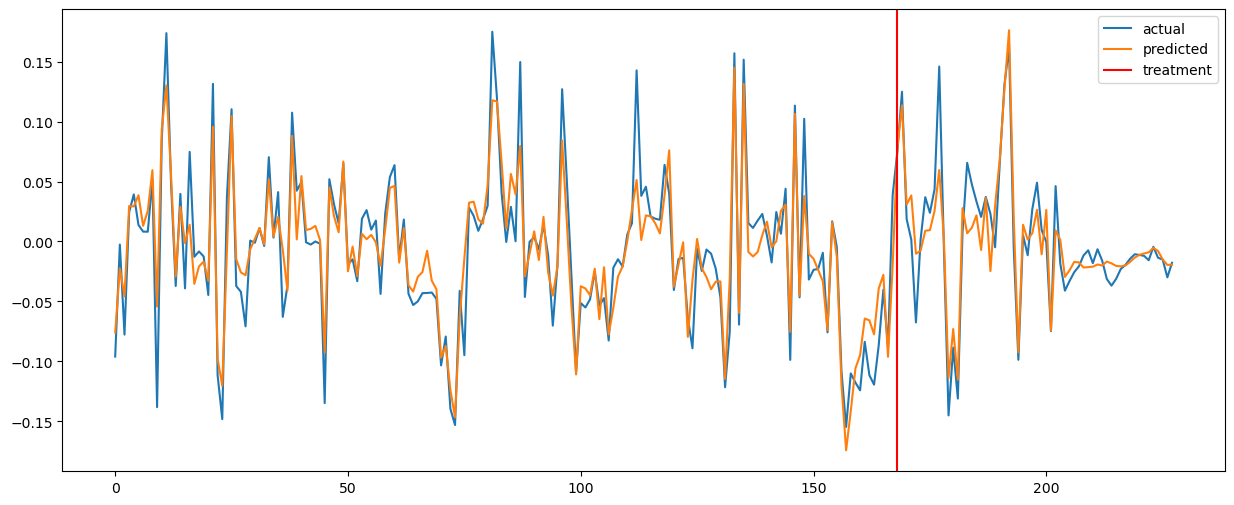

In [106]:
x_ax = X_orig.index
act = TargetVarScalerFit.inverse_transform(y)
pred = TargetVarScalerFit.inverse_transform(model.predict(X).reshape(-1, 1))

plt.figure(figsize=(15,6))
plt.plot(act, label='actual')
plt.plot(pred, label='predicted')
plt.axvline(x = impl_year/(12*timescale), c='r', label='treatment')
plt.legend()
plt.plot();

[-0.02047968]
[0.05240735]


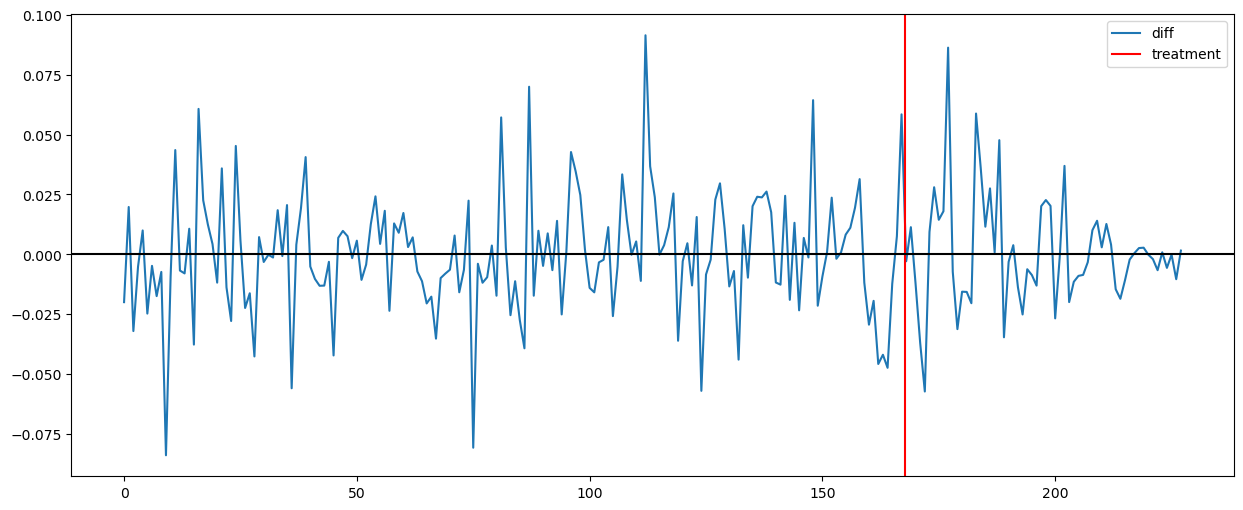

In [107]:
diff = act - pred
print(sum(diff[:round(impl_year/(12*timescale))]))
print(sum(diff[round(impl_year/(12*timescale)):]))

plt.figure(figsize=(15,6))
plt.plot(diff, label='diff')
plt.axvline(x = impl_year/(12*timescale), c='r', label='treatment')
plt.axhline(y=0, c='black')
plt.legend()
plt.plot();

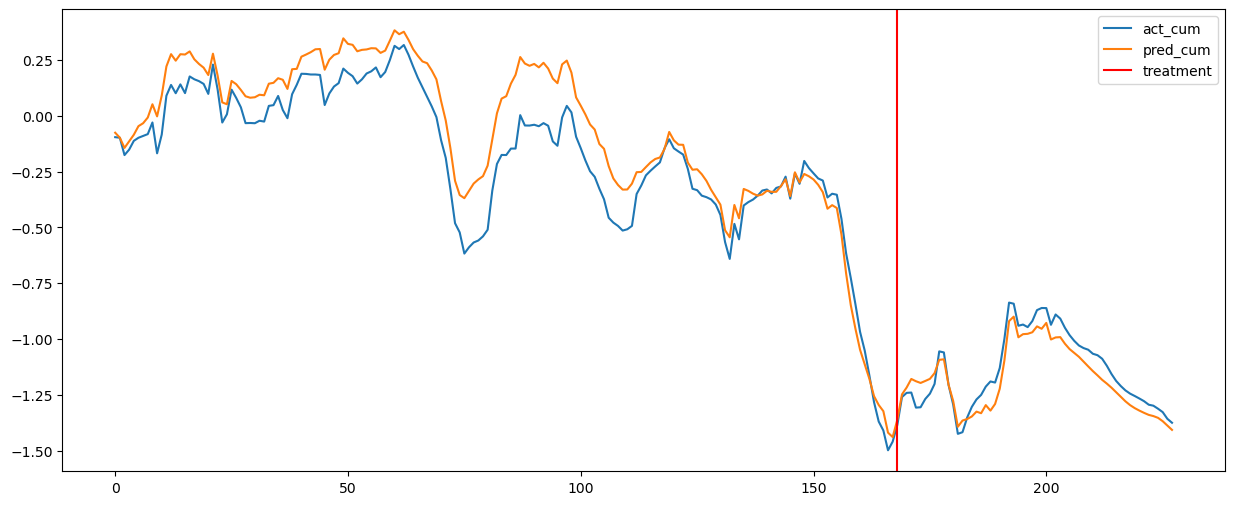

In [109]:
act_cum = np.cumsum(act)
pred_cum = np.cumsum(pred)

# act_cum = np.cumsum(act[round(impl_year/12):])
# pred_cum = np.cumsum(pred[round(impl_year/12):])

plt.figure(figsize=(15,6))
plt.plot(act_cum, label='act_cum')
plt.plot(pred_cum, label='pred_cum')
plt.axvline(x = impl_year/(12*timescale), c='r', label='treatment')
# plt.axvline(x = 0, c='r', label='treatment')
plt.legend()
plt.plot();